# requirements.txt

pip install keras==2.2.3 scikit-learn==0.19.0 tensorflow-gpu==1.15.0

pydot  if you have graphdot

source code is from https://github.com/smousavi05/Unsupervised_Deep_Learning

the file is from https://github.com/smousavi05/Unsupervised_Deep_Learning/blob/master/unsupervised_deep_learning.ipynb

In [1]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
import tensorflow.keras
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import idac_metrics as metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

Using TensorFlow backend.


In [2]:
import logging
logging.disable(30)   # disable the deprecated warning from tensorflow

# Loading the data

data in original paper

x = np.load('x.np.npy') # STFT of local and teleseismic waveforms
y = np.load('y.np.npy') # labels
n_clusters = 2

the shape is (size, 16, 48, 1)

Next, we will read our data

In [3]:
from scipy.io import loadmat
train_data = loadmat('earthb.mat')
all_data = train_data['images']
all_target = train_data['labels']

In [4]:
n_clusters = 3

In [5]:
from data_utils import get_data


data = get_data(all_data, all_target, dataset='eq', seed=1, shape=[-1, 50, 40, 3], select=None, norm=True)


2022-07-15 19:37:19.956 | INFO     | data_utils:normalization:12 - Normalization in range [-0.4522, 0.4593]


In [6]:
x_train, x_valid, x_test, y_train, y_valid, y_test, splits, splits_test = data
print('data shape %s' % str(x_train.shape) + str(x_valid.shape) + str(x_test.shape))

data shape (13883, 50, 40, 3)(1543, 50, 40, 3)(6612, 50, 40, 3)


In [7]:
x_train, x_valid, x_test = x_train[:, 5:45, :, :], x_valid[:, 5:45, :, :], x_test[:, 5:45, :, :]
print('data shape %s' % str(x_train.shape) + str(x_valid.shape) + str(x_test.shape))

data shape (13883, 40, 40, 3)(1543, 40, 40, 3)(6612, 40, 40, 3)


# Building the autoencoder

In [24]:
inp = Input(shape=(40, 40, 3))  
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(1, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(1, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(3, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
#autoencoder.summary()

# from keras.utils import plot_model
# plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='autoencoder.png')

# Pretraining of the autoencoder

In [29]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

import time
start = time.time()
autoencoder.fit(x_train, x_train, batch_size=128, epochs=30, callbacks=[csv_logger])

end = time.time()
print("training time on pretraining is ", end - start)

Epoch 1/30
13883/13883 [==============================] - 2s 127us/step - loss: 1.6148e-04
Epoch 2/30
13883/13883 [==============================] - 1s 73us/step - loss: 1.6077e-04
Epoch 3/30
13883/13883 [==============================] - 1s 75us/step - loss: 1.6070e-04
Epoch 4/30
13883/13883 [==============================] - 1s 74us/step - loss: 1.6062e-04
Epoch 5/30
13883/13883 [==============================] - 1s 73us/step - loss: 1.6052e-04
Epoch 6/30
13883/13883 [==============================] - 1s 81us/step - loss: 1.6039e-04
Epoch 7/30
13883/13883 [==============================] - 1s 80us/step - loss: 1.6012e-04
Epoch 8/30
13883/13883 [==============================] - 1s 81us/step - loss: 1.5905e-04
Epoch 9/30
13883/13883 [==============================] - 1s 73us/step - loss: 1.5781e-04
Epoch 10/30
13883/13883 [==============================] - 1s 76us/step - loss: 1.5735e-04
Epoch 11/30
13883/13883 [==============================] - 1s 75us/step - loss: 1.5709e-04
Epoch 1

# Now, adding the clustering layer into the bottelneck layer 

In [30]:
#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model.png')

...Finetuning...


# Finetuning of full network

In [31]:
### initializing the weights using Kmean and assigning them to the model
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])


In [32]:
metrics.acc(y_train, y_pred)

0.4264928329611755

In [35]:

## parameters for the finetuning
batch_size = 128
tol = 0.001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter = 5000
update_interval = int(x_train.shape[0] / batch_size) + 1
index_array = np.arange(x_train.shape[0])

In [34]:
from utils import cluster_acc

In [36]:

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

start_finetune = time.time()

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        if y_train is not None:
            acc = np.round(metrics.acc(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d(Epoch %d): acc = %.5f' % (ite, ite // update_interval, acc), ' ; loss=', loss, '; time = ', time.time() - start_finetune)
            cluster_acc(y_train, y_pred)
            

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

#         if ite > 0 and delta_label < tol:
#             print('delta_label ', delta_label, '< tol ', tol)
#             break
        
        IN = encoder.predict(x_train)        
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=[p[idx], x_train[idx]])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0  

end_finetune = time.time()

print('pretraining time=', end - start, 'fine tune time =', end_finetune - start_finetune, 'iterations:', maxiter)

print('fine tune speed: seconds per epoch', (end_finetune - start_finetune) / maxiter * update_interval)

2022-07-15 19:43:32.308 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4265 | 0.4265 | 0.4265
2022-07-15 19:43:32.312 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3801 | 0.3667 | 0.3592
2022-07-15 19:43:32.315 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4127 | 0.4265 | 0.4042


Iter 0(Epoch 0): acc = 0.42649  ; loss= 0 ; time =  1.144502878189087


2022-07-15 19:43:36.092 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3916 | 0.3916 | 0.3916
2022-07-15 19:43:36.095 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3706 | 0.3637 | 0.3661
2022-07-15 19:43:36.098 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3975 | 0.3916 | 0.3936


Iter 109(Epoch 1): acc = 0.39163  ; loss= [0.00015 0.      0.00015] ; time =  4.928821563720703


2022-07-15 19:43:38.124 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3787 | 0.3787 | 0.3787
2022-07-15 19:43:38.127 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3835 | 0.4004 | 0.3808
2022-07-15 19:43:38.130 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3938 | 0.3787 | 0.3761


Iter 218(Epoch 2): acc = 0.37874  ; loss= [0.00015 0.      0.00015] ; time =  6.960818290710449


2022-07-15 19:43:40.368 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3743 | 0.3743 | 0.3743
2022-07-15 19:43:40.371 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3727 | 0.3827 | 0.3730
2022-07-15 19:43:40.374 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3853 | 0.3743 | 0.3751


Iter 327(Epoch 3): acc = 0.37434  ; loss= [0.00015 0.      0.00015] ; time =  9.204825401306152


2022-07-15 19:43:42.491 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3665 | 0.3665 | 0.3665
2022-07-15 19:43:42.495 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3573 | 0.3609 | 0.3572
2022-07-15 19:43:42.498 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3724 | 0.3665 | 0.3673


Iter 436(Epoch 4): acc = 0.36649  ; loss= [0.00015 0.      0.00015] ; time =  11.328062534332275


2022-07-15 19:43:44.737 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3660 | 0.3660 | 0.3660
2022-07-15 19:43:44.740 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3551 | 0.3579 | 0.3547
2022-07-15 19:43:44.743 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3709 | 0.3660 | 0.3665


Iter 545(Epoch 5): acc = 0.36599  ; loss= [0.00015 0.      0.00015] ; time =  13.573465347290039


2022-07-15 19:43:46.919 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3687 | 0.3687 | 0.3687
2022-07-15 19:43:46.922 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3578 | 0.3607 | 0.3578
2022-07-15 19:43:46.925 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3738 | 0.3687 | 0.3696


Iter 654(Epoch 6): acc = 0.36872  ; loss= [1.5e-04 1.0e-05 1.4e-04] ; time =  15.756539583206177


2022-07-15 19:43:49.041 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3699 | 0.3699 | 0.3699
2022-07-15 19:43:49.044 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3614 | 0.3655 | 0.3618
2022-07-15 19:43:49.047 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3770 | 0.3699 | 0.3716


Iter 763(Epoch 7): acc = 0.36995  ; loss= [0.00016 0.00013 0.00014] ; time =  17.878106355667114


2022-07-15 19:43:51.169 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3791 | 0.3791 | 0.3791
2022-07-15 19:43:51.172 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3723 | 0.3768 | 0.3724
2022-07-15 19:43:51.175 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3886 | 0.3791 | 0.3817


Iter 872(Epoch 8): acc = 0.37910  ; loss= [0.00045 0.0031  0.00014] ; time =  20.005810260772705


2022-07-15 19:43:53.375 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3870 | 0.3870 | 0.3870
2022-07-15 19:43:53.378 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3804 | 0.3842 | 0.3801
2022-07-15 19:43:53.381 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3972 | 0.3870 | 0.3901


Iter 981(Epoch 9): acc = 0.38702  ; loss= [0.00173 0.01585 0.00014] ; time =  22.211782693862915


2022-07-15 19:43:55.654 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3914 | 0.3914 | 0.3914
2022-07-15 19:43:55.657 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3828 | 0.3847 | 0.3820
2022-07-15 19:43:55.660 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4010 | 0.3914 | 0.3947


Iter 1090(Epoch 10): acc = 0.39141  ; loss= [0.003   0.02858 0.00015] ; time =  24.491480588912964


2022-07-15 19:43:57.858 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3933 | 0.3933 | 0.3933
2022-07-15 19:43:57.862 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3829 | 0.3829 | 0.3814
2022-07-15 19:43:57.865 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4025 | 0.3933 | 0.3967


Iter 1199(Epoch 11): acc = 0.39329  ; loss= [0.00387 0.03725 0.00015] ; time =  26.69501519203186


2022-07-15 19:44:00.120 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3983 | 0.3983 | 0.3983
2022-07-15 19:44:00.123 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3853 | 0.3831 | 0.3829
2022-07-15 19:44:00.127 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4062 | 0.3983 | 0.4012


Iter 1308(Epoch 12): acc = 0.39826  ; loss= [0.00449 0.04341 0.00015] ; time =  28.95399570465088


2022-07-15 19:44:02.250 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3993 | 0.3993 | 0.3993
2022-07-15 19:44:02.253 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3819 | 0.3783 | 0.3791
2022-07-15 19:44:02.256 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4046 | 0.3993 | 0.4011


Iter 1417(Epoch 13): acc = 0.39927  ; loss= [0.00501 0.04867 0.00015] ; time =  31.08711862564087


2022-07-15 19:44:04.445 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3981 | 0.3981 | 0.3981
2022-07-15 19:44:04.448 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3763 | 0.3715 | 0.3728
2022-07-15 19:44:04.451 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4009 | 0.3981 | 0.3985


Iter 1526(Epoch 14): acc = 0.39811  ; loss= [0.00547 0.05324 0.00015] ; time =  33.28182077407837


2022-07-15 19:44:06.617 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.3993 | 0.3993 | 0.3993
2022-07-15 19:44:06.620 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3719 | 0.3671 | 0.3683
2022-07-15 19:44:06.623 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3987 | 0.3993 | 0.3977


Iter 1635(Epoch 15): acc = 0.39934  ; loss= [0.00583 0.05682 0.00015] ; time =  35.45426893234253


2022-07-15 19:44:08.753 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4018 | 0.4018 | 0.4018
2022-07-15 19:44:08.757 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3686 | 0.3644 | 0.3648
2022-07-15 19:44:08.760 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3972 | 0.4018 | 0.3976


Iter 1744(Epoch 16): acc = 0.40179  ; loss= [0.00611 0.05961 0.00015] ; time =  37.5898973941803


2022-07-15 19:44:10.978 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4065 | 0.4065 | 0.4065
2022-07-15 19:44:10.982 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3681 | 0.3650 | 0.3642
2022-07-15 19:44:10.986 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3980 | 0.4065 | 0.3997


Iter 1853(Epoch 17): acc = 0.40654  ; loss= [0.00635 0.06202 0.00015] ; time =  39.812801361083984


2022-07-15 19:44:13.280 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4093 | 0.4093 | 0.4093
2022-07-15 19:44:13.283 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3658 | 0.3643 | 0.3621
2022-07-15 19:44:13.286 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3969 | 0.4093 | 0.3998


Iter 1962(Epoch 18): acc = 0.40928  ; loss= [0.00653 0.06383 0.00015] ; time =  42.11694049835205


2022-07-15 19:44:15.399 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4148 | 0.4148 | 0.4148
2022-07-15 19:44:15.403 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3675 | 0.3673 | 0.3639
2022-07-15 19:44:15.406 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3994 | 0.4148 | 0.4032


Iter 2071(Epoch 19): acc = 0.41475  ; loss= [0.0067  0.06555 0.00015] ; time =  44.23628044128418


2022-07-15 19:44:17.626 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4179 | 0.4179 | 0.4179
2022-07-15 19:44:17.629 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3667 | 0.3679 | 0.3633
2022-07-15 19:44:17.632 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3998 | 0.4179 | 0.4044


Iter 2180(Epoch 20): acc = 0.41792  ; loss= [0.00686 0.06716 0.00015] ; time =  46.46320056915283


2022-07-15 19:44:19.721 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4203 | 0.4203 | 0.4203
2022-07-15 19:44:19.725 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3656 | 0.3683 | 0.3626
2022-07-15 19:44:19.728 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.3999 | 0.4203 | 0.4052


Iter 2289(Epoch 21): acc = 0.42030  ; loss= [0.007   0.06853 0.00015] ; time =  48.55824422836304


2022-07-15 19:44:21.874 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4224 | 0.4224 | 0.4224
2022-07-15 19:44:21.877 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3660 | 0.3694 | 0.3633
2022-07-15 19:44:21.880 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4010 | 0.4224 | 0.4067


Iter 2398(Epoch 22): acc = 0.42239  ; loss= [0.00708 0.06932 0.00015] ; time =  50.710857629776


2022-07-15 19:44:24.045 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4241 | 0.4241 | 0.4241
2022-07-15 19:44:24.048 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3664 | 0.3708 | 0.3642
2022-07-15 19:44:24.051 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4019 | 0.4241 | 0.4082


Iter 2507(Epoch 23): acc = 0.42412  ; loss= [0.00708 0.06931 0.00015] ; time =  52.88162159919739


2022-07-15 19:44:26.201 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4269 | 0.4269 | 0.4269
2022-07-15 19:44:26.205 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3677 | 0.3735 | 0.3667
2022-07-15 19:44:26.208 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4039 | 0.4269 | 0.4110


Iter 2616(Epoch 24): acc = 0.42685  ; loss= [0.00703 0.06878 0.00015] ; time =  55.03781867027283


2022-07-15 19:44:28.264 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4282 | 0.4282 | 0.4282
2022-07-15 19:44:28.268 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3684 | 0.3749 | 0.3682
2022-07-15 19:44:28.272 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4054 | 0.4282 | 0.4129


Iter 2725(Epoch 25): acc = 0.42822  ; loss= [0.00698 0.06835 0.00015] ; time =  57.09971070289612


2022-07-15 19:44:30.426 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4297 | 0.4297 | 0.4297
2022-07-15 19:44:30.429 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3700 | 0.3768 | 0.3703
2022-07-15 19:44:30.432 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4075 | 0.4297 | 0.4151


Iter 2834(Epoch 26): acc = 0.42966  ; loss= [0.00692 0.06774 0.00015] ; time =  59.26328372955322


2022-07-15 19:44:32.599 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4307 | 0.4307 | 0.4307
2022-07-15 19:44:32.602 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3725 | 0.3783 | 0.3725
2022-07-15 19:44:32.605 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4102 | 0.4307 | 0.4172


Iter 2943(Epoch 27): acc = 0.43074  ; loss= [0.00687 0.06719 0.00015] ; time =  61.43529176712036


2022-07-15 19:44:34.778 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4318 | 0.4318 | 0.4318
2022-07-15 19:44:34.781 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3745 | 0.3793 | 0.3741
2022-07-15 19:44:34.784 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4126 | 0.4318 | 0.4190


Iter 3052(Epoch 28): acc = 0.43175  ; loss= [0.00681 0.0666  0.00015] ; time =  63.61430263519287


2022-07-15 19:44:36.992 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4336 | 0.4336 | 0.4336
2022-07-15 19:44:36.995 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3782 | 0.3811 | 0.3769
2022-07-15 19:44:36.999 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4168 | 0.4336 | 0.4221


Iter 3161(Epoch 29): acc = 0.43362  ; loss= [0.0068  0.06644 0.00015] ; time =  65.82814335823059


2022-07-15 19:44:39.296 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4338 | 0.4338 | 0.4338
2022-07-15 19:44:39.300 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3801 | 0.3811 | 0.3778
2022-07-15 19:44:39.303 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4194 | 0.4338 | 0.4234


Iter 3270(Epoch 30): acc = 0.43384  ; loss= [0.00681 0.06655 0.00015] ; time =  68.13114857673645


2022-07-15 19:44:41.669 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4340 | 0.4340 | 0.4340
2022-07-15 19:44:41.673 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3842 | 0.3816 | 0.3799
2022-07-15 19:44:41.677 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4234 | 0.4340 | 0.4254


Iter 3379(Epoch 31): acc = 0.43398  ; loss= [0.00681 0.06661 0.00015] ; time =  70.50336456298828


2022-07-15 19:44:44.007 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4325 | 0.4325 | 0.4325
2022-07-15 19:44:44.011 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3884 | 0.3804 | 0.3810
2022-07-15 19:44:44.014 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4278 | 0.4325 | 0.4263


Iter 3488(Epoch 32): acc = 0.43247  ; loss= [0.00683 0.0668  0.00015] ; time =  72.84070634841919


2022-07-15 19:44:46.326 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4312 | 0.4312 | 0.4312
2022-07-15 19:44:46.330 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3924 | 0.3799 | 0.3823
2022-07-15 19:44:46.334 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4318 | 0.4312 | 0.4274


Iter 3597(Epoch 33): acc = 0.43117  ; loss= [0.00686 0.06708 0.00015] ; time =  75.16052174568176


2022-07-15 19:44:48.567 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4271 | 0.4271 | 0.4271
2022-07-15 19:44:48.572 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3952 | 0.3764 | 0.3811
2022-07-15 19:44:48.576 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4350 | 0.4271 | 0.4262


Iter 3706(Epoch 34): acc = 0.42714  ; loss= [0.00694 0.06791 0.00015] ; time =  77.39619016647339


2022-07-15 19:44:51.010 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4272 | 0.4272 | 0.4272
2022-07-15 19:44:51.014 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3803 | 0.3753 | 0.3755
2022-07-15 19:44:51.018 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4218 | 0.4272 | 0.4219


Iter 3815(Epoch 35): acc = 0.42721  ; loss= [0.00709 0.06933 0.00015] ; time =  79.84034013748169


2022-07-15 19:44:53.346 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4361 | 0.4361 | 0.4361
2022-07-15 19:44:53.350 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3820 | 0.3842 | 0.3816
2022-07-15 19:44:53.353 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4239 | 0.4361 | 0.4283


Iter 3924(Epoch 36): acc = 0.43614  ; loss= [0.0073  0.07147 0.00015] ; time =  82.18117880821228


2022-07-15 19:44:55.658 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4434 | 0.4434 | 0.4434
2022-07-15 19:44:55.661 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3823 | 0.3915 | 0.3859
2022-07-15 19:44:55.665 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4247 | 0.4434 | 0.4328


Iter 4033(Epoch 37): acc = 0.44342  ; loss= [0.00754 0.07389 0.00015] ; time =  84.49248051643372


2022-07-15 19:44:57.902 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4521 | 0.4521 | 0.4521
2022-07-15 19:44:57.905 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3829 | 0.4000 | 0.3904
2022-07-15 19:44:57.908 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4261 | 0.4521 | 0.4379


Iter 4142(Epoch 38): acc = 0.45206  ; loss= [0.00783 0.07673 0.00016] ; time =  86.73893928527832


2022-07-15 19:45:00.176 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4585 | 0.4585 | 0.4585
2022-07-15 19:45:00.180 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3832 | 0.4068 | 0.3936
2022-07-15 19:45:00.182 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4268 | 0.4585 | 0.4413


Iter 4251(Epoch 39): acc = 0.45847  ; loss= [0.00805 0.07896 0.00016] ; time =  89.01352262496948


2022-07-15 19:45:02.404 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4627 | 0.4627 | 0.4627
2022-07-15 19:45:02.407 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3827 | 0.4112 | 0.3951
2022-07-15 19:45:02.411 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4268 | 0.4627 | 0.4430


Iter 4360(Epoch 40): acc = 0.46265  ; loss= [0.00824 0.08081 0.00016] ; time =  91.2388207912445


2022-07-15 19:45:04.560 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4661 | 0.4661 | 0.4661
2022-07-15 19:45:04.563 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3824 | 0.4153 | 0.3964
2022-07-15 19:45:04.566 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4267 | 0.4661 | 0.4442


Iter 4469(Epoch 41): acc = 0.46611  ; loss= [0.00837 0.08212 0.00016] ; time =  93.39611387252808


2022-07-15 19:45:06.828 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4695 | 0.4695 | 0.4695
2022-07-15 19:45:06.832 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3823 | 0.4196 | 0.3977
2022-07-15 19:45:06.835 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4272 | 0.4695 | 0.4455


Iter 4578(Epoch 42): acc = 0.46950  ; loss= [0.00847 0.08311 0.00016] ; time =  95.66265034675598


2022-07-15 19:45:09.086 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4719 | 0.4719 | 0.4719
2022-07-15 19:45:09.091 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3823 | 0.4233 | 0.3986
2022-07-15 19:45:09.096 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4274 | 0.4719 | 0.4460


Iter 4687(Epoch 43): acc = 0.47194  ; loss= [0.00854 0.08388 0.00016] ; time =  97.91162395477295


2022-07-15 19:45:11.351 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4755 | 0.4755 | 0.4755
2022-07-15 19:45:11.355 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3836 | 0.4279 | 0.4005
2022-07-15 19:45:11.358 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4287 | 0.4755 | 0.4475


Iter 4796(Epoch 44): acc = 0.47547  ; loss= [0.00851 0.08349 0.00016] ; time =  100.1865758895874


2022-07-15 19:45:13.677 | INFO     | utils:prec_recall_f1:10 - precision recall  F1 score in    micro:  0.4768 | 0.4768 | 0.4768
2022-07-15 19:45:13.680 | INFO     | utils:prec_recall_f1:13 - precision recall  F1 score in    macro:  0.3840 | 0.4306 | 0.4009
2022-07-15 19:45:13.684 | INFO     | utils:prec_recall_f1:16 - precision recall  F1 score in weighted:  0.4291 | 0.4768 | 0.4473


Iter 4905(Epoch 45): acc = 0.47677  ; loss= [0.00843 0.08275 0.00016] ; time =  102.51109290122986
pretraining time= 32.79255199432373 fine tune time = 103.89491558074951 iterations: 5000
seconds per epoch 2.2649091596603395


In [37]:
enc = encoder.predict(x_train[:3000])   # the data is large, TSNE is slow, so use a small subset
print('Get features, then TSNE')
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)


Get features, then TSNE


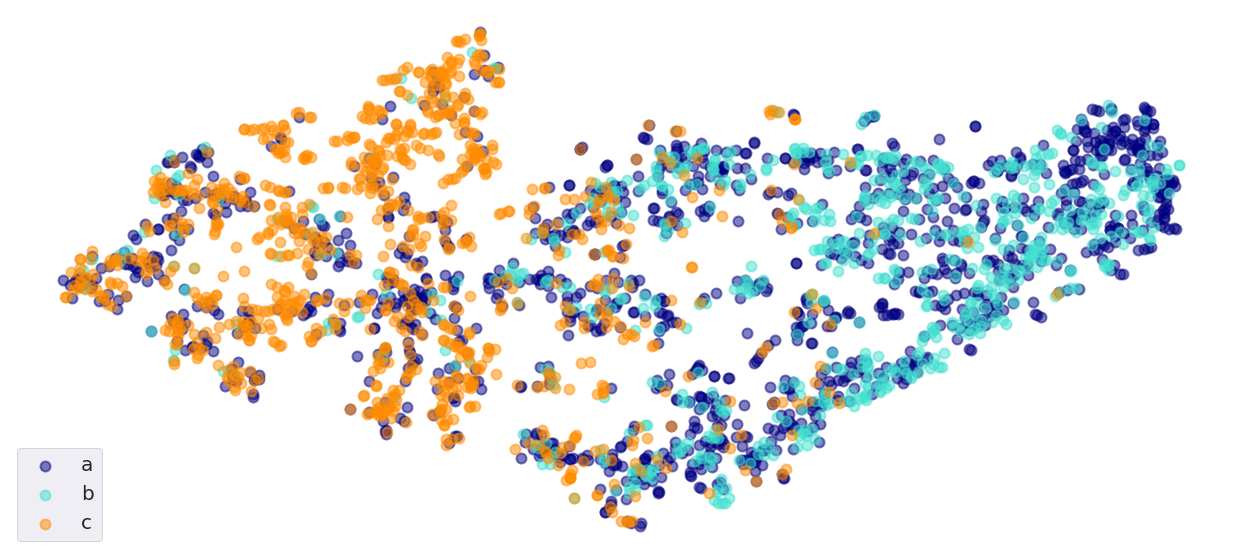

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8839e396a0>)

In [38]:
def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 20})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()

    return f, ax


target_names = ['a', 'b', 'c']
plotter(redu, y_train[:3000], target_names) 